# Importing Modules

We will import the basics and few specialty modules to be used within the analysis.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
% matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.ticker as tkr
import geocoder as geo
import datetime as dt
import cleandata as cd

# Getting Started

To get started, we will first describe the data. The majority of the analysis will be centered around felony incidents in New York City and the school violence incidents within NYC schools. For our analysis, we will also need population data as well as school location data.


To be clear, we will be analyzing a limited felony dataset of 7 different types, For our purposes, we will be using the general wikipedia definitions. Note that these definitions can sometimes change from state to state:
- Grand larceny: theft of personal property having a value above a legally specified amount.
- Robbery: the taking of another person's property by force, fear, or intimidation, with the intent to permanently deprive that person of the property.
- Burglary: typically defined as the unlawful entry into almost any structure (not just a home or business) with the intent to commit any crime inside (not just theft/larceny). No physical breaking and entering is required; the offender may simply trespass through an open door. Unlike robbery, which involves use of force or fear to obtain another person's property, there is usually no victim present during a burglary.
- Assault: carried out by a threat of bodily harm coupled with an apparent, present ability to cause the harm.
- Grand Larceny of Motor Vehicle: the unlawful taking of property — in this case, a vehicle — that belongs to someone else, done with the intent to permanently deprive the owner of the property.
- Rape: non-consensual sexual intercourse that is committed by physical force, threat of injury, or other duress
- Murder & Non-negligent Manslaughter: The unjustifiable, inexcusable, and intentional killing of a human being with (murder) or without (non-negligent) deliberation, premeditation, and malice.


# Importing Data

Import the felony data, population data, school violence data (VADIR files), and school location information. 

In [5]:
# Direct Loading - no exra manipulation needed
felony_df = pd.read_csv("NYPD_7_Major_Felony_Incidents.csv", parse_dates = "Occurrence Date")
borough_df = pd.read_csv("New_York_City_Population_By_Boroughs.csv")
location_df = pd.read_excel("15-16SchoolDirectory.xlsx")

### VADIR (School Violence) -  Dataset Clean Up

The following clean up items needed to be done in order to accurately analyze the VADIR data set.  We created a "cleandata" module with various functions to be used below.

* The 2010 - 2014 files have the same column names, so they're easy to import and concatenate. However, 2006 - 2009 years each have a few unique column names, so they must be concatenated independently to the main dataframe. 
* Moreover, some columns have "w/ weapon" and others have "w/out weapon" in the column names. These were suffixed with "_ww" and "_nw" for 'with weapon' and 'no weapon', respectively. 
* Also re-ordered columns, merged duplicate columns, removed problematic (non data) rows from the csv, and fixed inconsistencies. 
* Tallied number of incidents in total, with weapons, without weapons.

In [3]:
#define excel file list to import to analyze for mismatched columns in order to determine which ones need to be merged
df_list = ['VADIR_2007.xls', 'VADIR_2008.xls', 'VADIR_2009.xls', 'VADIR_2010.xls', 'VADIR_2011.xls', 'VADIR_2012.xls',
           'VADIR_2013.xls', 'VADIR_2014.xls', 'VADIR_2015.xls']

#define master excel file to use as the column file of record
df_to_use = 'VADIR_2015.xls'

#this function determines the column differecnes between each of the excel files 
#passed in by returning a dictionary of the file and columns that are not in the 
#master excel file definied above
unmatched_c = cd.vadir_get_cnames_replace(df_list, df_to_use)
#unmatched_c

#we then used what was returned in unmatched_c to create the below dictionary to replace duplicate columns
#when concatenating all of the data frames below
replace_dict = {'County Name':'County', 'District Name': 'District', 'BEDS CODE': 'BEDS Code', 
                'Other Sex offenses': 'Other Sex Offenses', 'Other Sex offenses': 'Other Sex Offenses',
                'Use Possession or Sale of Drugs': 'Drug Possession', 
                'Use Possession or Sale of Alcohol': 'Alcohol Possession',
                'Other Disruptive Incidents': 'Other Disruptive Incidents', 
                'Drug Possesion': 'Drug Possession', 'Alcohol Possesion': 'Alcohol Possession', 
                'Other Disruptive': 'Other Disruptive Incidents'}

#this is a dictionary of years and the respective files to be concatenated 
#the year is used as a new column in the concatenated data frame
df_dict = {2007: 'VADIR_2007.xls', 2008: 'VADIR_2008.xls', 2009: 'VADIR_2009.xls', 2010: 'VADIR_2010.xls', 2011: 'VADIR_2011.xls', 
         2012: 'VADIR_2012.xls', 2013: 'VADIR_2013.xls', 2014: 'VADIR_2014.xls', 2015: 'VADIR_2015.xls'}

#this is a list of columns to be used as the columns that appear in the beginning of the data frame
beginner_columns = ['School Name', 'School Type', 'School Year', 'BEDS Code',  'County', 'District', 'Enrollment', 
                    'Grade Organization', 'Need/Resource Category']
vadir_df = cd.vadir_concat_dfs(df_dict, replace_dict)
vadir_df = cd.vadir_reorder_columns(vadir_df, beginner_columns)

all_columns = vadir_df.columns.tolist()
tally_columns = [c for c in all_columns if c not in beginner_columns]

#this creates tallied columns of total offenses, total with weapon offenses and total without weapon offenses 
#for the school for the year
vadir_df = cd.vadir_create_tallies(vadir_df, tally_columns)
school_df = cd.vadir_clean_concat_df(vadir_df)

... data from VADIR_2007.xls appended. Added 1455 rows for a total of 1455.
... data from VADIR_2008.xls appended. Added 1500 rows for a total of 2955.
... data from VADIR_2009.xls appended. Added 1545 rows for a total of 4500.
... data from VADIR_2010.xls appended. Added 1531 rows for a total of 6031.
... data from VADIR_2011.xls appended. Added 1678 rows for a total of 7709.
... data from VADIR_2012.xls appended. Added 1693 rows for a total of 9402.
... data from VADIR_2013.xls appended. Added 1735 rows for a total of 11137.
... data from VADIR_2014.xls appended. Added 1792 rows for a total of 12929.
... data from VADIR_2015.xls appended. Added 1805 rows for a total of 14734.


### Borough Population Data - Cleanup

In [6]:
# capitalize borough and set them as index (to match NYPD Data)
borough_df.Borough = borough_df.Borough.apply(lambda x : x.upper())
borough_df.set_index('Borough', inplace = True)

# Add areas (measured in sq miles, source: wikipedia)
borough_df["Area(sq mi)"] = pd.Series({'BRONX': 42.47 , 'BROOKLYN': 69.5, 'MANHATTAN': 22.82 ,
                                'QUEENS': 108.1 , 'STATEN ISLAND': 57.92 })
# Take  a look
borough_df

,2000 Population,2010 Population,Area(sq mi)
Borough,,,
BRONX,1332650,1385108,42.47
BROOKLYN,2465326,2504700,69.50
MANHATTAN,1537195,1585873,22.82
QUEENS,2229379,2230722,108.10
STATEN ISLAND,443728,468730,57.92


# NYPD 7 Major Felony Incidents


In [7]:
print("Number of observations:", len(felony_df), "\nNumber of Variables:", len(felony_df.columns),\
     "\nDate Range:", int(felony_df["Occurrence Year"].min()), "-", int(felony_df["Occurrence Year"].max()))

Number of observations: 1123465 
Number of Variables: 20 
Date Range: 1905 - 2015


Percent of data dated 2000 or after: 99.45%


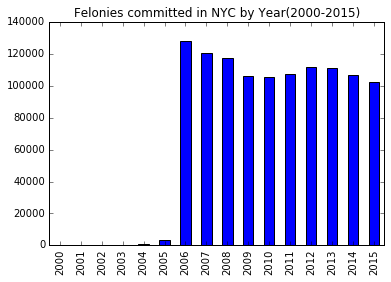

In [8]:
# what percent of the data is from 2006 and after?
year_counts = felony_df['Occurrence Year'].value_counts()
recent = year_counts[list(range(2006,2016))].sum()
print("Percent of data dated 2000 or after: {:.2f}%".format(recent/1123465 * 100))

# plot crime incidence by year (2000- 2015)
year_counts[list(range(2000,2016))].plot(kind = 'bar')
plt.title("Felonies committed in NYC by Year(2000-2015)")

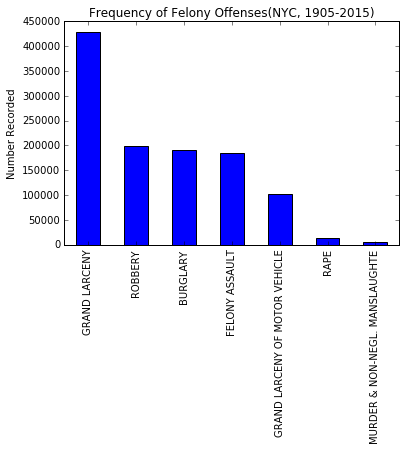

In [9]:
# plot crime incidence by felony type (whole data set)
felony_counts = felony_df.Offense.value_counts()
#counts.sort_values(inplace=True)
felony_counts.plot(kind = 'bar')
plt.title("Frequency of Felony Offenses(NYC, 1905-2015)")
plt.ylabel("Number Recorded")

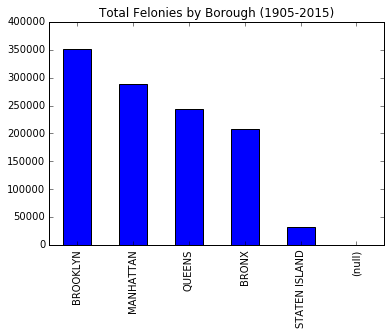

In [10]:
# plot crime incidence by borough (whole data set)
felony_df.Borough.value_counts().plot(kind = 'bar')
plt.title("Total Felonies by Borough (1905-2015)")

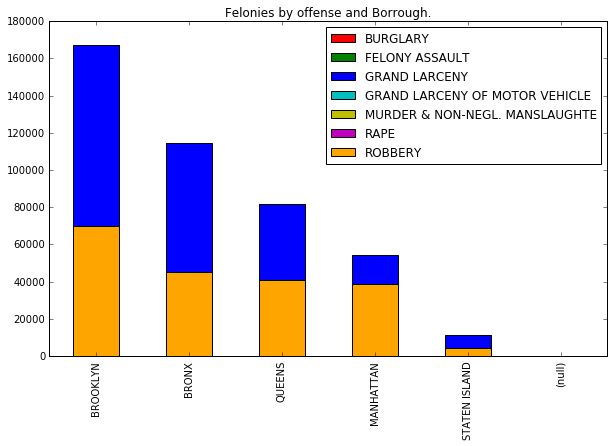

In [11]:
# plotting by borough and offense
fig, ax = plt.subplots()

ind = np.arange(5)
width = 0.25
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'orange']
counter = 0
for off, df in felony_df.groupby('Offense'):
    df.Borough.value_counts().plot(kind = 'bar', color = colors[counter], label = off, figsize = (10,6))
    counter += 1

plt.title("Felonies by offense and Borrough.")
plt.legend()
       

### Set up Felony data to do temporal analysis

In [13]:
# Note: This cell takes 5-10 minutes to run

felony_df = pd.read_csv("NYPD_7_Major_Felony_Incidents.csv", parse_dates = "Occurrence Date")

#creating a new column to strip off Time from Occurrence Date
felony_df['Short Occurrence Date']= pd.to_datetime(felony_df['Occurrence Date'])
felony_df['Short Occurrence Date'] = [d.strftime('%Y-%m-%d') if not pd.isnull(d) else '' for d \
                                      in felony_df['Short Occurrence Date']]

#removing data prior to 2006
felony_df_2006 = felony_df[felony_df["Occurrence Year"]>2005]

#there are some dates that have a year of 2006 and higher but a date of 1900, removing these as well
felony_df_2006 = felony_df[felony_df["Short Occurrence Date"]>'2005-12-31'] 

month_order = {'Jan':'01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 
               'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
felony_df_2006['Occurrence Month Ordered'] = [month_order[m] + ' ' + m for m in \
                                              felony_df_2006['Occurrence Month']]

day_order = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
felony_df_2006['Day of Week Ordered'] = [str(day_order[d]) + ' ' + d for d in felony_df_2006['Day of Week']]

#groupby by several parameters for plots

datecount = felony_df_2006.groupby('Short Occurrence Date', as_index=False)['OBJECTID'].count()
yearcount = felony_df_2006.groupby('Occurrence Year', as_index=False)['OBJECTID'].count()
monthcount = felony_df_2006.groupby('Occurrence Month Ordered', as_index=False)['OBJECTID'].count()
daycount = felony_df_2006.groupby('Occurrence Day', as_index=False)['OBJECTID'].count()
weekdaycount = felony_df_2006.groupby('Day of Week Ordered', as_index=False)['OBJECTID'].count()
offensecount = felony_df_2006.groupby('Offense', as_index=False)['OBJECTID'].count()
yearoffensecount = felony_df_2006.groupby(['Occurrence Year', 'Offense'], as_index=False)['OBJECTID'].count()
yearoffensecountp = yearoffensecount.pivot('Occurrence Year', 'Offense', 'OBJECTID')

C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


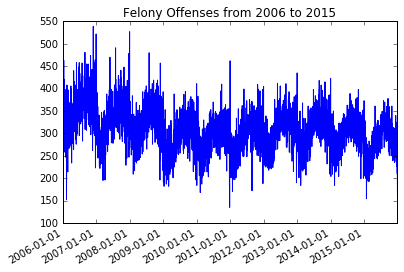

In [16]:
# get a time series view of the number of offenses per day
dates = datecount["Short Occurrence Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = datecount["OBJECTID"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2006 to 2015')

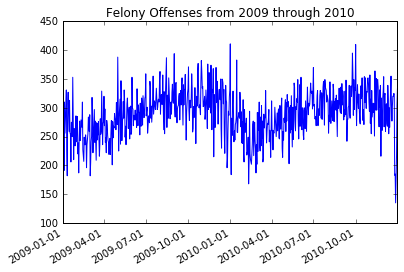

In [17]:
# there is an evident seasonal spike and valley in felonies each year
# the below shows a view for 2009 through 2010
datecount_2010 = datecount[datecount['Short Occurrence Date'] > '2008-12-31']
datecount_2010 = datecount_2010[datecount_2010['Short Occurrence Date'] < '2011-01-01']

dates = datecount_2010["Short Occurrence Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = datecount_2010["OBJECTID"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2009 through 2010')

#looks like the number of felonies spike in September/October and 
# then fall back down at the end of each calendar year

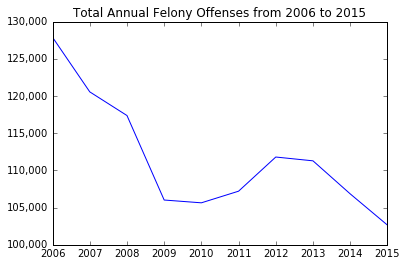

In [18]:
# this shows a decline in the number of felonies recorded from 2006 to 2015
# same graph as aaron had with the x axis labels as the years and y ticks labaels formatted
x = yearcount['Occurrence Year']
xlabels = [int(xl) for xl in x]
y = yearcount["OBJECTID"]

def func(x, pos):  
   s = '{:0,d}'.format(int(x))
   return s

y_format = tkr.FuncFormatter(func) 
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.plot(x,y)
plt.title('Total Annual Felony Offenses from 2006 to 2015')

In [19]:
# wanted to see a breakout of the type of offenses across years

# x = yearoffensecountp.index
# xlabels = [int(xl) for xl in x]
# yb = yearoffensecountp["BURGLARY"]
# yfa = yearoffensecountp["FELONY ASSAULT"]
# ygl = yearoffensecountp["GRAND LARCENY"]
# yglmv = yearoffensecountp["GRAND LARCENY OF MOTOR VEHICLE"]
# ymm = yearoffensecountp["MURDER & NON-NEGL. MANSLAUGHTE"]
# yr = yearoffensecountp["RAPE"]
# yrb = yearoffensecountp["ROBBERY"]

# def func(x, pos):  
#    s = '{:0,d}'.format(int(x))
#    return s

# y_format = tkr.FuncFormatter(func) 
# plt.xticks(x, xlabels)
# plt.gca().yaxis.set_major_formatter(y_format)

# plt.plot(x, yb, 'b-', label='Burglary')
# plt.plot(x, yfa, 'g-', label='Felony Assault')
# plt.plot(x, ygl, 'r-', label='Grand Larceny')
# plt.plot(x, yglmv, 'y-', label='Grand Larceny - Motor')
# plt.plot(x, ymm, 'k-', label='Murder')
# plt.plot(x, yr, 'm-', label='Rape')
# plt.plot(x, yrb, 'c-', label='Robbery')

# plt.legend(loc="best", bbox_to_anchor=[1, 1],
#            ncol=2, shadow=True, title="Legend", fancybox=True)
# plt.title('Felony Offenses by Type from 2006 to 2015')
# plt.show()

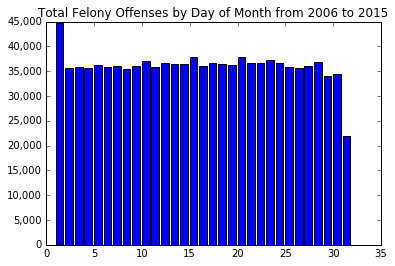

In [20]:
# there is a look of total felony offenses by day of week
# looks like the first of the month has the highest offenses - about 10,000 more than any other day
# perhaps this is just the busiest day to record offenses?
# 31 doesn't have as many offenses since not all months have 31 days - most likely
x = daycount['Occurrence Day']
y = daycount['OBJECTID']
plt.gca().yaxis.set_major_formatter(y_format)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Month from 2006 to 2015')

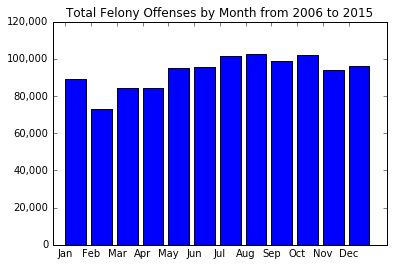

In [21]:
# breaking out the offenses by month total, it does look a bit seasonal and similar to the time series chart above
# February has the least number of offenses - potentially due to the cold weather in nyc
# need to determine how to center the month x axis tick labels
x = range(len(monthcount['Occurrence Month Ordered']))
xlabels = [x[-3:] for x in monthcount['Occurrence Month Ordered']]
y = monthcount['OBJECTID']
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-0.5,len(xlabels)+0.5)
locs = np.arange(len(xlabels))
plt.bar(x,y)
plt.title('Total Felony Offenses by Month from 2006 to 2015')
plt.show()

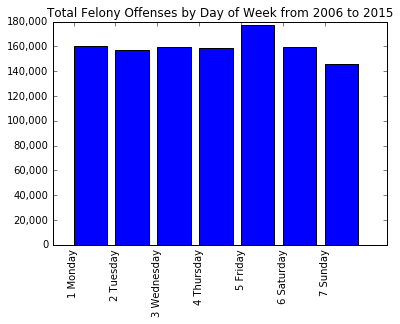

In [22]:
# breaking out offenses by day of week, Friday spikes with almost 20,000 more offenses than any other day
x = range(len(weekdaycount['Day of Week Ordered']))
xlabels = [x for x in weekdaycount['Day of Week Ordered']]
y = weekdaycount['OBJECTID']
plt.xticks(x, xlabels, rotation='vertical')
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-0.5,len(xlabels)+0.5)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Week from 2006 to 2015')
plt.show()

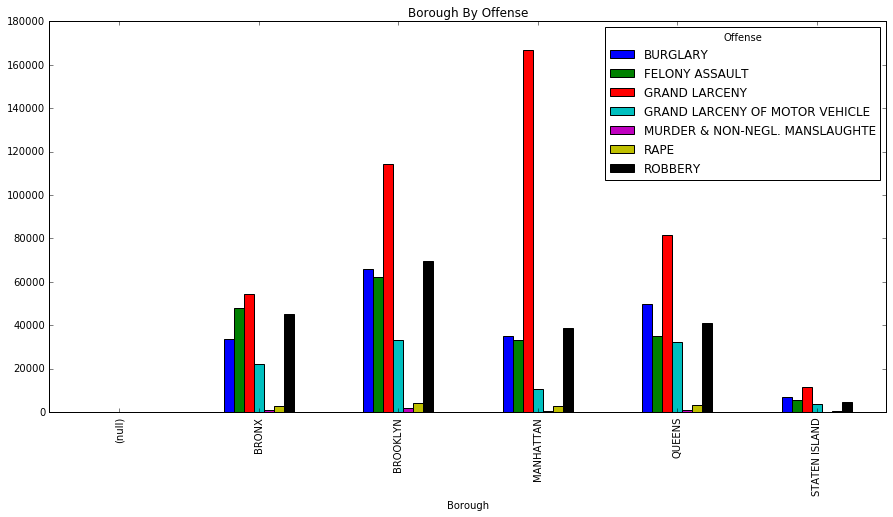

In [23]:
# create plot comparing types of Felonies by Borough
fel_by_bor = felony_df.groupby('Borough')['Offense'].value_counts().sort_values(ascending=False)
fel_by_bor_un = fel_by_bor.unstack("Offense")
fel_by_bor_un.sort_index(ascending=False, level = 'GRAND LARCENY')
fel_by_bor_un.plot(kind="bar", figsize= (15,7), title = "Borough By Offense")

# School Data Analysis

In [25]:
school_df[school_df["School Year"].astype(int) > 2010]

,School Name,School Type,School Year,BEDS Code,County,District,Enrollment,Grade Organization,Need/Resource Category,Alcohol Possession,...,Reckless Endangerment_ww,Riot_nw,Riot_ww,Robbery_nw,Robbery_ww,Weapon Possession_oc,Weapon Possession_ts,Total Incidents,Incidents w/ Weapons,Incidents w/o Weapons
6031,Academic Leadership Charter School,Charter,2011,320700860957,Bronx,NaN,207,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
6032,Bronx Academy Of Promise Charter School,Charter,2011,320900860913,Bronx,NaN,314,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
6033,Bronx Charter School For Better Learning,Charter,2011,321100860855,Bronx,NaN,373,Elementary,Charter School,0,...,0,0,0,0,0,0,0,37,0,22
6034,Bronx Charter School For Children,Charter,2011,320700860852,Bronx,NaN,429,Elementary,Charter School,0,...,0,0,0,0,0,0,0,75,0,22
6035,Bronx Charter School For Excellence,Charter,2011,321100860859,Bronx,NaN,382,Elementary,Charter School,0,...,0,0,0,0,0,0,0,5,0,5
6036,Bronx Charter School For The Arts,Charter,2011,320800860846,Bronx,NaN,308,Elementary,Charter School,0,...,0,0,0,0,0,0,0,32,0,32
6037,Bronx Community Charter School,Charter,2011,321000860914,Bronx,NaN,176,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
6038,Bronx Global Learning Institute For Girls Char...,Charter,2011,320700860915,Bronx,NaN,199,Elementary,Charter School,0,...,0,0,0,0,0,0,0,6,0,3
6039,Bronx Lighthouse Charter School,Charter,2011,321200860870,Bronx,NaN,479,Elementary,Charter School,0,...,0,0,0,0,0,0,0,105,0,58
6040,Bronx Preparatory Charter School,Charter,2011,320900860807,Bronx,NaN,695,Junior Senior School,Charter School,3,...,0,0,0,0,0,0,0,42,1,38


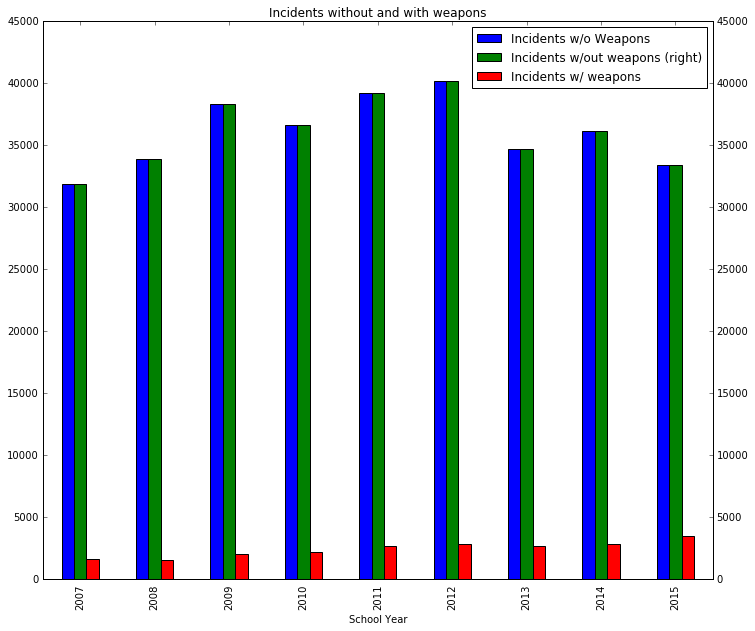

In [26]:
school_df["School Year"] = school_df["School Year"].astype(int)

if 'Incidents w/ Weapons' in school_df.columns:
    school_df.drop('Incidents w/ Weapons', axis =1, inplace=True)

if 'Incidents w/ Weapons.1' in school_df.columns:
    school_df.drop('Incidents w/ Weapons.1', axis =1, inplace=True)

if 'Incidents w/ weapons' in school_df.columns:
    school_df.drop('Incidents w/ weapons', axis =1, inplace=True)
    
if 'Incidents w/out weapons' in school_df.columns:
    school_df.drop('Incidents w/out weapons', axis =1, inplace=True)

nw_cols = [cols for cols in school_df.columns if 'nw' in cols]
school_df[nw_cols].sum(axis=1)
school_df["Incidents w/out weapons"] = school_df[nw_cols].sum(axis=1)

ww_cols = [cols for cols in school_df.columns if 'ww' in cols]
school_df[ww_cols].sum(axis=1)
school_df["Incidents w/ weapons"] = school_df[ww_cols].sum(axis=1)

inc_cols = [cols for cols in school_df.columns if cols.startswith("Inc")]
#school_df.drop(inc_cols[1], inplace = True, axis=1)
# school_df[inc_cols].head()

fig = school_df.groupby("School Year")[inc_cols].sum().plot(kind="bar", figsize = (12, 10), 
                                                      secondary_y = inc_cols[1], legend=True,
#                                                       xticks = range(2006,2016), 
                                                      title = "Incidents without and with weapons"
                                                      )

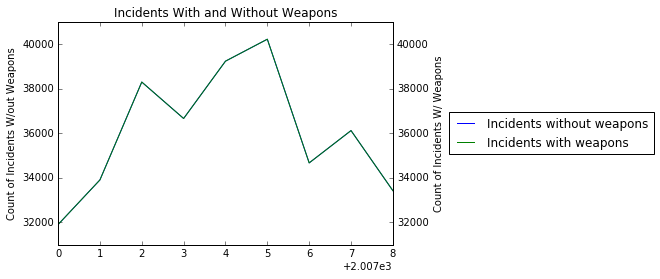

In [27]:
fig, ax = plt.subplots()

ax.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[0]].sum(),
        'b',
       label = "Incidents without weapons")
ax.set_ylabel("Count of Incidents W/out Weapons")

ax2 = ax.twinx()
ax2.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[1]].sum(),
         'g',
       label = "Incidents with weapons")
ax2.set_ylabel("Count of Incidents W/ Weapons")

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc = "center left", bbox_to_anchor = (1.15, 0.5))
ax.set_title("Incidents With and Without Weapons")
plt.show()

## Create Lat/Lon values using Geocoder based on addresses

In [36]:
# Finds which schools exist in both the violence and location dataframes

#location_df = pd.read_csv("15-16SchoolDirectory.csv") #removing this since this was imported above

loc_sed = set(location_df["SED CODE"].astype(np.int64))
sch_beds = set(school_df["BEDS Code"].astype(np.int64))
print("Location file school count:", len(loc_sed), "\nSchool violence school count:", len(sch_beds),
      "\nSchools with both violence and locations:", len(loc_sed & sch_beds))
school_beds_with_addresses = [x for x in sch_beds if x in (loc_sed & sch_beds)]
filtered_school_df = school_df[school_df["BEDS Code"].isin(school_beds_with_addresses)]
filtered_school_df.reset_index(inplace = True, drop = True)

Location file school count: 7200 
School violence school count: 1967 
Schools with both violence and locations: 1807


In [49]:
#LR - Created a beds_df that will also house the lat lon info

location_df["Full_Address"] = location_df["MAILING ADDRESS"] + ", " + location_df["CITY"] + \
                                ", " + location_df["STATE"] + ", " + location_df["ZIP"]

beds_df = location_df[location_df['SED CODE'].isin(school_beds_with_addresses)][['SED CODE', 'LEGAL NAME', 'Full_Address']]

In [37]:
# Note: Takes 30 seconds to run
#LR - wasn't able to get this to run without errors

# Creates Full Address column in both location df and filtered school df
location_df["Full_Address"] = location_df["MAILING ADDRESS"] + ", " + location_df["CITY"] + \
                                ", " + location_df["STATE"] + ", " + location_df["ZIP"] 

filtered_school_df["Full_Address"] = [location_df[location_df["SED CODE"] == x].Full_Address for \
                                      x in filtered_school_df["BEDS Code"]]

filtered_school_df.Full_Address = [str(filtered_school_df.Full_Address[x])[8:].split("Name")[0][:-1] for x\
                                   in range(len(filtered_school_df.Full_Address))]

# # Need unique school list only to get below 2,500 records to use geocoder (1,807 total)
beds_list = [] # format of [beds code, address, school name]
for beds in (loc_sed & sch_beds):
    beds_list.append([beds, filtered_school_df[filtered_school_df["BEDS Code"]==beds].Full_Address.values[0],\
                filtered_school_df[filtered_school_df["BEDS Code"]==beds]["School Name"].values[0]])

beds_df = pd.DataFrame(beds_list, columns = ["BEDS_Code", "Address", "SchoolName"])
print("There are", len(beds_df), "unique schools in beds_df.")
beds_df.head()

C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


IndexError: index 0 is out of bounds for axis 0 with size 0

## WARNING: The next cell can only be run once a day.

It takes at least 10 minutes to run as well. This is a limitation of Google - only 2500 calls can be made per day and the cell below calls it 1,807 times.

In [51]:
# Takes 10 min at least for all 1,807 schools! Only works ONCE A DAY due to geocoder 
# restrictions with Google (2,500 calls per day)

latlon = [geo.google(x).latlng for x in beds_df.Full_Address]
beds_df["latlon"] = latlon
beds_df.head()


,SED CODE,LEGAL NAME,Full_Address,latlon
2140,300000010777,BUREAU FOR HUNTER COLL CAMPUS SCHOOL,"71 E 94TH ST, NEW YORK, NY, 10128","[40.7858238, -73.9538841]"
2142,307500011035,PS 35,"317 W 52ND ST, NEW YORK, NY, 10019","[40.7640485, -73.985947]"
2143,307500011079,PS 79 HORAN SCHOOL,"55 E 120TH ST, NEW YORK, NY, 10035","[40.80250880000001, -73.94237050000001]"
2144,307500011094,PS 94,"55 BATTERY PL, NEW YORK, NY, 10001","[40.70656290000001, -74.0175278]"
2145,307500011138,PS 138,"144-176 E 128TH ST, NEW YORK, NY, 10035","[40.8057191, -73.9353352]"


## END WARNING

In [ ]:
# Add "Lat" and "Lon" columns on the filtered school dataframe

latlon_list = [beds_df.latlon[beds_df[beds_df["BEDS_Code"]==x].index.values[0]] for x in filtered_school_df["BEDS Code"]]
filtered_school_df["Lat"] = [x[0] if x!=[] else [] for x in latlon_list]
filtered_school_df["Lon"] = [x[1] if x!=[] else [] for x in latlon_list]
filtered_school_df[["Full_Address", "Lat", "Lon"]].head()

In [52]:
beds_df.to_csv("SchoolLatLon.csv")